## fine tune bert model for custom dataset

### 1. install libraries

In [ ]:
! pip install transformers

In [ ]:
! pip install imbalanced-learn

### 2. load/define data set

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('data/banking.csv')

In [7]:
# str labels to int
df['intlabel'] = df['label'].rank(method='dense', ascending=False).astype(int) - 1

In [8]:
# prepare mapping from int labels back to str
def getmapping(data: pd.DataFrame) -> dict:
    """
    :param data: data frame with 'intlabel' columns containing int values 
        and 'label' column containing str values
    :return: mapping from int values to str
    """
    labelmapping = {}
    for key in data.intlabel.unique():
        value = data.loc[data['intlabel'] == key,'label'].unique()[0]
        labelmapping[key] = value
    return labelmapping

In [9]:
print(df.shape)
df.sample(frac=1).head()

(173, 3)


,text,label,intlabel
75,co mohu zadat,pomoc,16
117,"Potřeboval bych nastavit souhlas s inkasem, al...",zadat_inkaso,9
81,co teď,pomoc,16
93,Dobré odpoledne,pozdrav,14
152,změnit trvalý příkaz,zmenit_trvaly_prikaz,4


In [10]:
# count how many samples per label in the dataset
dfcounts = df.groupby('label').size().reset_index(name='counts')
dfcounts

,label,counts
0,all_in_one,2
1,bez_predcisli,3
2,blokace_karty,9
3,dekuji,4
4,go_back,5
5,hotovo,9
6,jednorazova_platba,17
7,jiny_email,4
8,jiny_ucet,2
9,konec,6


In [11]:
# retrieve labels that have minimum number of samples
dfmincounts = dfcounts[dfcounts.counts > 2]

In [12]:
# remove data with labels that have less than minimum number of samples
df = df[df.label.isin(dfmincounts.label.tolist())]
df['intlabel'] = df['label'].rank(method='dense', ascending=False).astype(int) - 1
df.groupby('label').size().reset_index(name='counts')

,label,counts
0,bez_predcisli,3
1,blokace_karty,9
2,dekuji,4
3,go_back,5
4,hotovo,9
5,jednorazova_platba,17
6,jiny_email,4
7,konec,6
8,odeslani_platby,5
9,pomoc,20


In [13]:
labelmapping = getmapping(df)
n_labels = len(labelmapping.values())
n_labels

23

In [14]:
texts = df.text.tolist()
labels = df.intlabel.tolist()

In [15]:
trntxt, tsttxt, trnlbl, tstlbl = train_test_split(texts, labels, test_size=0.2)

### 3. preprocess text

#### 3.1 balance training dataset

In [16]:
# take a look into training data distribution to decide if balancing is necessary
dftrn = pd.DataFrame({'text': trntxt, 'label': [labelmapping[key] for key in trnlbl], 'intlabel': trnlbl})
dftrn.groupby('label').size().reset_index(name='counts')

,label,counts
0,bez_predcisli,2
1,blokace_karty,7
2,dekuji,3
3,go_back,5
4,hotovo,8
5,jednorazova_platba,16
6,jiny_email,2
7,konec,5
8,odeslani_platby,4
9,pomoc,15


In [17]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

In [18]:
sampler = RandomOverSampler(random_state=42)

In [19]:
trntxt = np.asarray(trntxt)
trntxt = trntxt[:, np.newaxis]

In [20]:
trntxt, trnlbl = sampler.fit_resample(trntxt, trnlbl)
trntxt = trntxt.flatten().tolist()

In [21]:
# chech the result of balancing
dftrn = pd.DataFrame({'text': trntxt, 'label': [labelmapping[key] for key in trnlbl], 'intlabel': trnlbl})
dftrn.groupby('label').size().reset_index(name='counts')

,label,counts
0,bez_predcisli,16
1,blokace_karty,16
2,dekuji,16
3,go_back,16
4,hotovo,16
5,jednorazova_platba,16
6,jiny_email,16
7,konec,16
8,odeslani_platby,16
9,pomoc,16


#### 3.2 encode string data with tokenizer

In [22]:
from transformers import AutoTokenizer

/home/barinale/miniconda3/envs/ner/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# load the same tokenizer a model was trained with
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

Downloading: 100%|██████████████████████████████████████████████████████| 723/723 [00:00<00:00, 583kB/s]
Downloading: 100%|█████████████████████████████████████████████████| 4.83M/4.83M [00:02<00:00, 2.53MB/s]
Downloading: 100%|█████████████████████████████████████████████████| 8.66M/8.66M [07:21<00:00, 20.6kB/s]
Downloading: 100%|█████████████████████████████████████████████████████| 239/239 [00:00<00:00, 41.0kB/s]


In [26]:
trnencodings = tokenizer(trntxt, truncation=True, padding=True)
tstencodings = tokenizer(tsttxt, truncation=True, padding=True)

In [27]:
trndata = [{'label': label, 'input_ids': inid, 'attention_mask': atmask} for label, inid, atmask in zip(trnlbl, trnencodings['input_ids'], trnencodings['attention_mask'])]
tstdata = [{'label': label, 'input_ids': inid, 'attention_mask': atmask} for label, inid, atmask in zip(tstlbl, tstencodings['input_ids'], tstencodings['attention_mask'])]

### 4. load pretrained model

In [28]:
from transformers import AutoModelForSequenceClassification

In [29]:
model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", num_labels=n_labels)

Downloading: 100%|█████████████████████████████████████████████████| 1.04G/1.04G [07:02<00:00, 2.63MB/s]
Some weights of the model checkpoint at sentence-transformers/paraphrase-multilingual-mpnet-base-v2 were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-mpnet-base-v2 and are newly 

### 5. Fit model on a custom dataset

In [30]:
from transformers import TrainingArguments, Trainer

In [31]:
training_args = TrainingArguments(
    output_dir="./tunedbert",
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_strategy="epoch",
    num_train_epochs=10,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trndata,
    eval_dataset=tstdata,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 368
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 230


In [68]:
history = np.asarray(trainer.state.log_history[:-1])
loss = history[::2]
evalloss = history[1::2]
loss = [entry['loss'] for entry in loss]
evalloss = [entry['eval_loss'] for entry in evalloss]

In [3]:
import matplotlib.pyplot as plt

In [70]:
def learningcurve(loss: list, evalloss: list):
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epochs = np.arange(len(loss))
    plt.plot(epochs, loss, color='b')
    plt.plot(epochs, evalloss, color='r')
    plt.legend(['train loss', 'test loss'])
    plt.show()

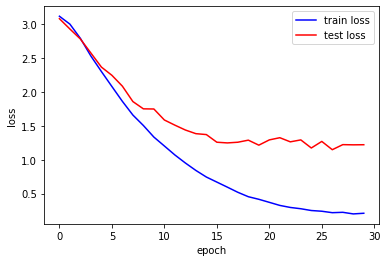

In [71]:
learningcurve(loss, evalloss)

### 6. Test trained model

In [4]:
import time

In [72]:
start = time.time()
rawpredictions = trainer.predict(tstdata)
predtime = time.time() - start
pred_intlabels = np.argmax(rawpredictions.predictions, axis=1)
pred_labels = [labelmapping[lbl] for lbl in pred_intlabels]
gt_intlabels = np.array([entry['label'] for entry in tstdata])
gt_labels = [labelmapping[lbl] for lbl in gt_intlabels]

***** Running Prediction *****
  Num examples = 33
  Batch size = 16


In [73]:
correct = np.sum(pred_intlabels == gt_intlabels)
accuracy = correct / gt_intlabels.shape[0]
f"ACCURACY: {accuracy}; {correct} correct out of {gt_intlabels.shape[0]}"

'ACCURACY: 0.696969696969697; 23 correct out of 33'

In [74]:
result = [{'text': txt, 'prediction': pred, 'ground truth': gt} for txt, pred, gt in zip(tsttxt, pred_labels, gt_labels)]
result

[{'text': 'Potřeboval bych nastavit souhlas s inkasem, ale nejde mi to.',
  'prediction': 'zrusit_inkaso',
  'ground truth': 'zadat_inkaso'},
 {'text': 'zrušit trvalý příkaz',
  'prediction': 'zrusit_trvaly_prikaz',
  'ground truth': 'zrusit_trvaly_prikaz'},
 {'text': 'kde to jsem', 'prediction': 'pomoc', 'ground truth': 'pomoc'},
 {'text': 'co mohu dělat', 'prediction': 'pomoc', 'ground truth': 'pomoc'},
 {'text': 'Jen si to připravím.',
  'prediction': 'konec',
  'ground truth': 'zadost_o_strpeni'},
 {'text': 'co se to děje', 'prediction': 'pomoc', 'ground truth': 'pomoc'},
 {'text': 'Jen si dojdu pro číslo účtu.',
  'prediction': 'zadat_trvaly_prikaz',
  'ground truth': 'zadost_o_strpeni'},
 {'text': 'chci odeslat platbu',
  'prediction': 'jednorazova_platba',
  'ground truth': 'odeslani_platby'},
 {'text': 'Koupil jsem si na internetu pračku, a potřebuji ji zaplatit.',
  'prediction': 'zruseni_platby',
  'ground truth': 'jednorazova_platba'},
 {'text': 'Díky', 'prediction': 'dekuji